In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
gold_data = pd.read_csv("data/130209min.csv")
macd_data = pd.read_csv("data/240209.csv")
macd_data['time'] = pd.to_datetime(macd_data['time'])
gold_data['time'] = pd.to_datetime(gold_data['time'], unit='s')

## RSI ##


In [ ]:



# Step 2: 计算布林带（20期）
gold_data['SMA_20'] = gold_data['close'].rolling(window=20).mean()
gold_data['std_20'] = gold_data['close'].rolling(window=20).std()
gold_data['bollinger_upper'] = gold_data['SMA_20'] + (gold_data['std_20'] * 2)
gold_data['bollinger_lower'] = gold_data['SMA_20'] - (gold_data['std_20'] * 2)

# Step 3: 计算RSI（14周期）
gold_data['price_change'] = gold_data['close'].diff()
gold_data['gain'] = np.where(gold_data['price_change'] > 0, gold_data['price_change'], 0)
gold_data['loss'] = np.where(gold_data['price_change'] < 0, -gold_data['price_change'], 0)
gold_data['avg_gain'] = gold_data['gain'].rolling(window=14).mean()
gold_data['avg_loss'] = gold_data['loss'].rolling(window=14).mean()
gold_data['rs'] = gold_data['avg_gain'] / gold_data['avg_loss']
gold_data['RSI'] = 100 - (100 / (1 + gold_data['rs']))

# Step 4: 删除NaN值
gold_data_cleaned = gold_data.dropna()

# Step 5: 创建交互式图表
fig = go.Figure()

# 添加布林带和金价
fig.add_trace(go.Scatter(x=gold_data_cleaned['time'], y=gold_data_cleaned['close'], mode='lines', name='Close Price'))
fig.add_trace(go.Scatter(x=gold_data_cleaned['time'], y=gold_data_cleaned['bollinger_upper'], mode='lines', name='Bollinger Upper', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=gold_data_cleaned['time'], y=gold_data_cleaned['bollinger_lower'], mode='lines', name='Bollinger Lower', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=gold_data_cleaned['time'], y=gold_data_cleaned['SMA_20'], mode='lines', name='SMA_20', line=dict(dash='dot')))

# 创建RSI图表
fig_rsi = go.Figure()
fig_rsi.add_trace(go.Scatter(x=gold_data_cleaned['time'], y=gold_data_cleaned['RSI'], mode='lines', name='RSI', line=dict(color='orange')))
fig_rsi.add_hline(y=70, line=dict(color='red', dash='dash'), name='Overbought (70)')
fig_rsi.add_hline(y=30, line=dict(color='green', dash='dash'), name='Oversold (30)')

# 设置布林带图表布局
fig.update_layout(
    title='Gold Price with Bollinger Bands',
    xaxis_title='Time',
    yaxis_title='Price',
    showlegend=True
)

# 设置RSI图表布局
fig_rsi.update_layout(
    title='RSI (14-period)',
    xaxis_title='Time',
    yaxis_title='RSI Value',
    showlegend=True
)

# 显示图表
fig.show()
fig_rsi.show()


In [ ]:
def find_support_with_atvv_rsi(df, window=14, atvv_threshold=1.5, rsi_threshold=30):
    """
    基于支撑位、atvv 和 RSI 的结合来判断支撑位的有效性。
    
    参数:
    df (pd.DataFrame): 输入数据集，必须包含 `close`、`low`、`atvv` 和 `RSI` 列。
    window (int): 计算最低价的窗口期，默认为14。
    atvv_threshold (float): atvv 动能阈值，用于确认动能是否足够强。
    rsi_threshold (float): RSI 阈值，判断超买和超卖，默认为30（超卖）。
    
    返回:
    df (pd.DataFrame): 返回包含支撑位和有效性确认的列。
    """
    # 计算过去 `window` 期的最低价作为支撑位
    df['support_level'] = df['low'].rolling(window=window).min()
    
    # 计算 atvv 的历史均值和标准差
    df['atvv_mean'] = df['ATVV'].rolling(window=window).mean()
    df['atvv_std'] = df['ATVV'].rolling(window=window).std()
    
    # 确定当 atvv 大于均值加上某个倍数的标准差时，动能是否足够强
    df['atvv_strong'] = np.where(df['ATVV'] > df['atvv_mean'] + atvv_threshold * df['atvv_std'], 1, 0)
    
    # 判断价格是否接近支撑位
    df['price_near_support'] = np.where((df['close'] <= df['support_level']), 1, 0)
    
    # 计算 RSI
    df['RSI'] = 100 - (100 / (1 + df['gain'] / df['loss']))
    
    # 当价格接近支撑位且 RSI 超卖（<30）且 atvv 强时，确认支撑位有效
    df['support_rebound'] = np.where(
        (df['price_near_support'] == 1) & (df['atvv_strong'] == 0) & (df['RSI'] < rsi_threshold), 1, 0)
    
    return df


In [ ]:
find_support_with_atvv_rsi(gold_data_cleaned)

In [2]:
def calculate_and_plot_macd(data, column='close', short_span=12, long_span=26, signal_span=9, plot=True):
    """
    计算 MACD 线、信号线和 MACD 柱，并可视化结果。
    
    参数:
    - data (pd.DataFrame): 包含价格数据的 DataFrame，必须包含指定的列（默认为 'close'）。
    - column (str): 用于计算 MACD 的价格列名，默认为 'close'。
    - short_span (int): 短期 EMA 的周期长度，默认为 12。
    - long_span (int): 长期 EMA 的周期长度，默认为 26。
    - signal_span (int): 信号线 EMA 的周期长度，默认为 9。
    - plot (bool): 是否绘制 MACD 图表，默认为 True。
    
    返回:
    - data (pd.DataFrame): 原始数据，附加 MACD 线、信号线和 MACD 柱的结果。
    """
    # 计算短期和长期 EMA
    data['EMA_{}'.format(short_span)] = data[column].ewm(span=short_span, adjust=False).mean()
    data['EMA_{}'.format(long_span)] = data[column].ewm(span=long_span, adjust=False).mean()
    
    # 计算 MACD 线（DIF）
    data['MACD'] = data['EMA_{}'.format(short_span)] - data['EMA_{}'.format(long_span)]
    
    # 计算信号线（DEA）
    data['Signal'] = data['MACD'].ewm(span=signal_span, adjust=False).mean()
    
    # 计算 MACD 柱（Histogram）
    data['MACD_histogram'] = data['MACD'] - data['Signal']
    
    if plot:
        # 绘制结果
        plt.figure(figsize=(14, 8))

        # 绘制价格图
        plt.subplot(2, 1, 1)
        plt.plot(data[column], label='Close Price', color='blue')
        plt.title('Price')
        plt.legend(loc='best')

        # 绘制 MACD 图表
        plt.subplot(2, 1, 2)
        plt.plot(data['MACD'], label='MACD Line', color='red')
        plt.plot(data['Signal'], label='Signal Line', color='green')
        plt.bar(data.index, data['MACD_histogram'], label='MACD Histogram', color='gray', alpha=0.5)
        plt.axhline(0, color='black', linewidth=1)
        plt.title('MACD & Signal Line')
        plt.legend(loc='best')

        plt.tight_layout()
        plt.show()

    return data


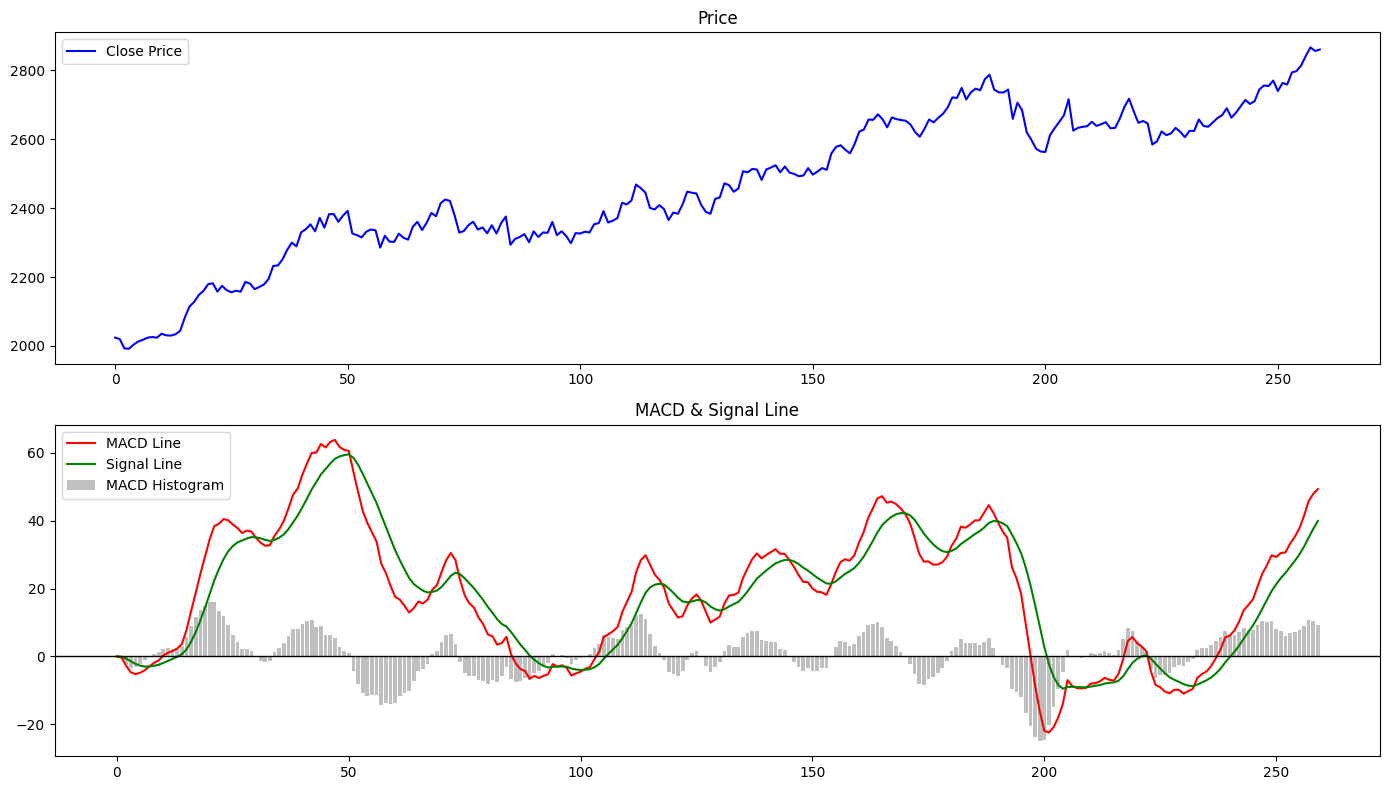

,time,open,high,low,close,ATVV,Plot,EMA_12,EMA_26,MACD,Signal,MACD_histogram
0,2024-02-09,2033.85,2037.240,2020.41,2024.155,0,0,2024.155000,2024.155000,0.000000,0.000000,0.000000
1,2024-02-12,2024.38,2027.580,2012.01,2019.885,0,0,2023.498077,2023.838704,-0.340627,-0.068125,-0.272501
2,2024-02-13,2019.63,2032.845,1990.22,1992.855,0,0,2018.783757,2021.543615,-2.759857,-0.606472,-2.153385
3,2024-02-14,1993.10,1996.120,1984.37,1991.980,0,0,2014.660102,2019.353717,-4.693615,-1.423900,-3.269714
4,2024-02-15,1991.98,2008.270,1990.32,2004.105,0,0,2013.036241,2018.224183,-5.187942,-2.176709,-3.011233
...,...,...,...,...,...,...,...,...,...,...,...,...
255,2025-02-03,2797.46,2830.570,2772.20,2814.130,0,0,2760.253720,2722.586287,37.667433,30.006386,7.661047
256,2025-02-04,2814.13,2845.480,2807.35,2841.400,0,0,2772.737763,2731.387303,41.350460,32.275201,9.075260
257,2025-02-05,2841.40,2882.390,2839.92,2866.235,0,0,2787.121953,2741.376021,45.745932,34.969347,10.776585
258,2025-02-06,2866.40,2873.300,2834.30,2855.810,0,0,2797.689345,2749.852612,47.836733,37.542824,10.293909


In [3]:
calculate_and_plot_macd(macd_data)